In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open("data/names.txt").read().split()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars  = sorted(list(set("".join(words))))
stoi = {char:i+1 for i,char in enumerate(chars)}
stoi["."] = 0
itos = {i:char for char,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3 # context length: how many characters do we take to predict the next one

X,Y = [],[]
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] #crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
C = torch.randn(27, 2)

In [14]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [15]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)   

In [16]:
torch.cat([emb[:,0,], emb[:,1,], emb[:,2,]], dim=1).shape

torch.Size([32, 6])

In [31]:
torch.cat(torch.unbind(emb, dim=1), dim=1).shape # one way to do it but less efficient

torch.Size([32, 6])

In [28]:
emb.shape
(emb.view(32,6) ==torch.cat([emb[:,0,], emb[:,1,], emb[:,2,]], dim=1)).all()

tensor(True)

In [34]:
h = torch.tanh(emb.view(32,6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [35]:
W2 = torch.randn(100,27)
b2 = torch.randn(27)

In [36]:
logits = h @ W2 + b2

In [37]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)

In [38]:
prob.shape

torch.Size([32, 27])

In [40]:
-prob[torch.arange(32), Y].log().mean()

tensor(16.4891)

rewrite for consice

In [50]:
X.shape, Y.shape #dataset

(torch.Size([32, 3]), torch.Size([32]))

In [51]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [52]:
sum(p.nelement() for p in parameters)

3481

In [53]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

In [57]:
logits = torch.tensor([-5, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

too high positive number overflows exp, so crossentropy normalizes input to avoid overflow
by substrating max value from input

distribution stay same

In [55]:
logits = torch.tensor([-5, -3, 0, 100])-100
print(logits)
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

In [72]:
block_size = 3 # context length: how many characters do we take to predict the next one

X,Y = [],[]
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] #crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [73]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [140]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [141]:
for p in parameters:
    p.requires_grad = True

In [142]:
# find lr
lre = torch.linspace(-3, 0, 1000) # beween 0.001 and 1, exponential scale
lrs = 10 ** lre

In [153]:
# lri = []
# lossi = []
for i in range(10000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    #forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    #backward pass
    for p in parameters: 
        p.grad = None
    loss.backward()
    # lr = lrs[i]
    lr = 0.1
    # lr = 0.01
    for p in parameters: 
        p.data += -lr * p.grad
    # lri.append(lre[i])
    # lossi.append(loss.item())
print(loss.item())

2.1670234203338623


In [154]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3057, grad_fn=<NllLossBackward0>)

findlr code

In [134]:
lri = []
lossi = []
for i in range(1000):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    #forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    #backward pass
    for p in parameters: 
        p.grad = None
    loss.backward()
    lr = lrs[i]
    for p in parameters: 
        p.data += -lr * p.grad
    lri.append(lre[i])
    lossi.append(loss.item())
# print(loss.item())

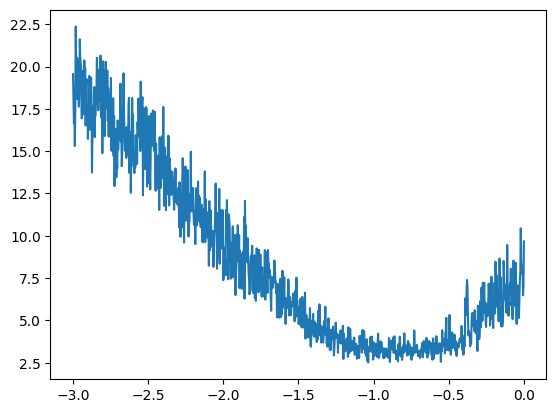

In [135]:
plt.plot(lri, lossi)

training split, dev/val split, test split
80% train, 10% dev, 10% test

evalute on test set a few times so you will not learn on it

In [175]:
def build_dataset(words):
    block_size = 3 
    X,Y = [],[]
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [176]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


In [184]:
# lr = 0.1
lr = 0.01 # decay
for i in range(10000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    #forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    #backward pass
    for p in parameters: 
        p.grad = None
    loss.backward()
    
    for p in parameters: 
        p.data += -lr * p.grad


In [185]:
print(loss.item())

2.3708014488220215


In [187]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3194, grad_fn=<NllLossBackward0>)

In [186]:
emb = C[Xva]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yva)
loss

tensor(2.3313, grad_fn=<NllLossBackward0>)

val and test perfomance are same because nn is too small to overfit

In [194]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


In [195]:
sum(p.nelement() for p in parameters)

10281

In [196]:
# lre = torch.linspace(-3, 0, 1000) # beween 0.001 and 1, exponential scale
# lrs = 10 ** lre

In [213]:
# lri = []
lossi = []
stepi = []
for i in range(30000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    #forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    #backward pass
    for p in parameters: 
        p.grad = None
    loss.backward()
    # lr = lrs[i]
    lr = 0.01
    for p in parameters: 
        p.data += -lr * p.grad
    stepi.append(i)
    lossi.append(loss.item())

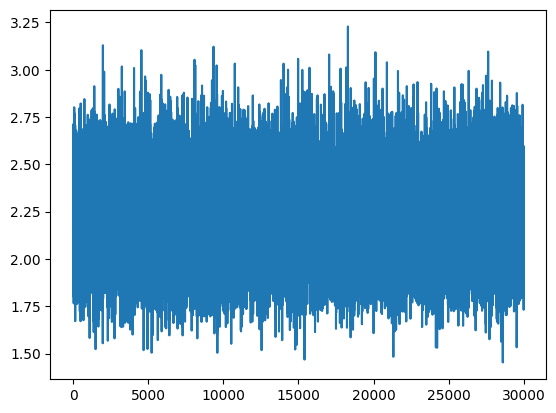

In [214]:
plt.plot(stepi, lossi)

In [215]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2103, grad_fn=<NllLossBackward0>)

In [216]:
emb = C[Xva]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yva)
loss

tensor(2.2399, grad_fn=<NllLossBackward0>)

bottleneck seems to be embedding size (2)

let's visualize embeddings

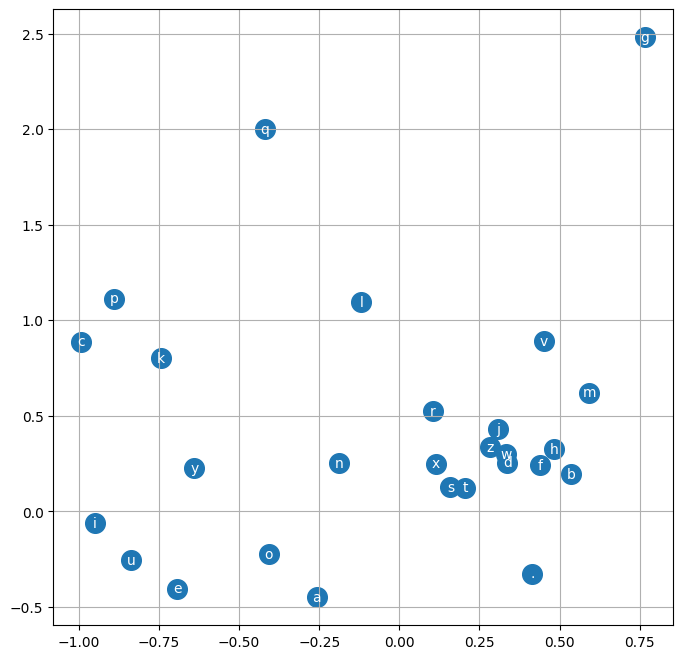

In [217]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

lets make embeddings bigger

In [249]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


In [250]:
sum(p.nelement() for p in parameters)

11897

In [251]:
# lri = []
lossi = []
stepi = []

In [252]:

for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    #forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    #backward pass
    for p in parameters: 
        p.grad = None
    loss.backward()
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters: 
        p.data += -lr * p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())

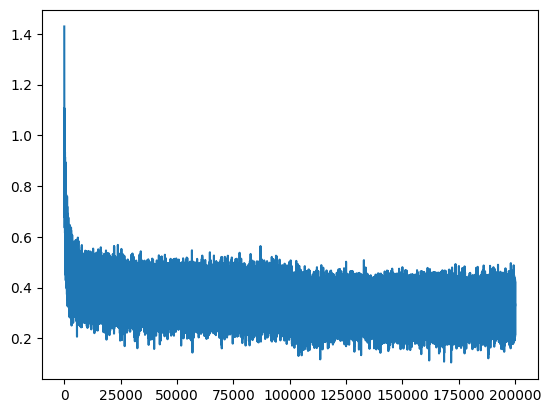

In [253]:
plt.plot(stepi, lossi)

In [254]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1245, grad_fn=<NllLossBackward0>)

In [255]:
emb = C[Xva]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yva)
loss

tensor(2.1803, grad_fn=<NllLossBackward0>)

In [257]:
emb = C[Xte]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1833, grad_fn=<NllLossBackward0>)

train and val has diff metrics - seems that model is big enough to start overfit

In [256]:
# sample from the model
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:]  + [ix]
        out.append(ix)
        if ix == 0: break

    print(''.join(itos[i] for i in out))

carmah.
amorie.
khylynn.
jeany.
skaashae.
rahnen.
delynn.
jareei.
ner.
kentzeriav.
kaleigh.
ham.
joir.
quinthonlie.
alianni.
watthma.
jaryn.
kai.
evells.
brex.


beat 2.1803 on val

In [258]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,20), generator=g)
W1 = torch.randn((20*3,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True


In [259]:
# lri = []
lossi = []
stepi = []

In [260]:

for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (64,))
    #forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,20*3) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    #backward pass
    for p in parameters: 
        p.grad = None
    loss.backward()
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters: 
        p.data += -lr * p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())

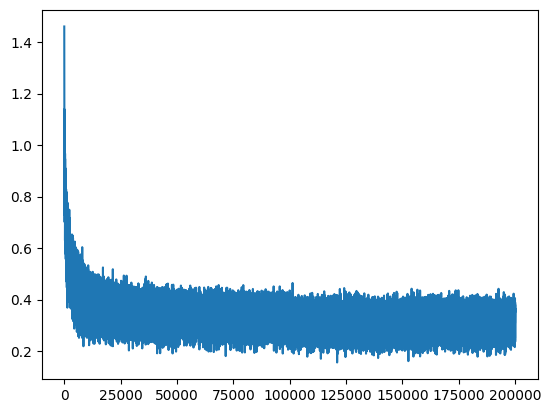

In [261]:
plt.plot(stepi, lossi)

In [263]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,20*3) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0520, grad_fn=<NllLossBackward0>)

In [264]:
emb = C[Xva]
h = torch.tanh(emb.view(-1,20*3) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yva)
loss

tensor(2.1502, grad_fn=<NllLossBackward0>)

In [265]:
emb = C[Xte]
h = torch.tanh(emb.view(-1,20*3) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1539, grad_fn=<NllLossBackward0>)

In [266]:
# sample from the model
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:]  + [ix]
        out.append(ix)
        if ix == 0: break

    print(''.join(itos[i] for i in out))

carmahzadillivi.
kimlie.
taty.
skanden.
jazhenna.
perric.
kaeli.
nellara.
chaiif.
kaleigh.
ham.
joce.
quint.
suline.
livani.
watell.
dearyn.
kai.
eveigh.
brextenii.
